# Chapter 6 - Exercises

## Set Up

### Packages

In [103]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from numpy.polynomial import polynomial as poly
from scipy import stats
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"
FOXES_FILE = "foxes.csv"

RANDOM_SEED = 42

### Functions

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

In [93]:
def smooth_plot_data(x, y, smooth_kwargs=None):
    if smooth_kwargs is None:
        smooth_kwargs = {}

    smooth_kwargs.setdefault("window_length", 55)
    smooth_kwargs.setdefault("polyorder", 2)
    x_data = np.linspace(x.min(), x.max(), 200)
    x_data[0] = (x_data[0] + x_data[1]) / 2
    y_interp = griddata(x, y, x_data)
    y_data = savgol_filter(y_interp, axis=0, **smooth_kwargs)

    return x_data, y_data

## Easy

### 6E1

List three mechanisms by which multiple regression can product false inferences about causal effects.

---

**Multicollinearity:** If two predictors have correlation, conditional on the target.
In this case, each individual predictor may help in predicting the outcome, but neither helps as much once you know the other.
This can make the coefficients non-identifiable and frustrate inference.

**Collider bias:** If two, unrelated, variables $X$ and $Y$ have a causal effect on a third $Z$, then conditioning on $Z$ can induce associations between $X$ and $Y$.
This is sometimes known as Berkson's paradox.

**Post-treatment bias:** Conditioning on a variable downstream of the variable of interest can frustrate the causal inference.
For example, if we want to understand the causal effect of an individual's parents' income on life expectancy, then conditioning on the individual's income might lead us to believe that parents' income has no causal effect.
But, this is disregarding the causal effect of parents' income on individual income.

### 6E2
For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

---

Among companies we mail, there is an inverse relationship between probability of sign-up and probability of funding.
However, this may not be a general association.
We select companies to mail based on an ROI threshold, so for us to have mailed a company with a low (predicted) probability of sign-up, it must have had a high (predicted) probability of funding.

### 6E3
List the four elemental confounds.
Can you explain the conditional dependencies of each?

---

**The fork:** $X$ and $Y$ are independent conditional on $Z$.

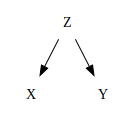

In [5]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("Z", "X")
g.edge("Z", "Y")
g

**The pipe:** $X$ and $Y$ are independent conditional on $Z$.

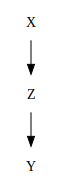

In [6]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Z", "Y")
g

**The collider:** $X$ and $Y$ are independent, but conditioning on $Z$ may induce association between them.

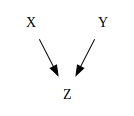

In [7]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Y", "Z")
g

**The descendant:** $X$ and $Y$ are independent, but conditioning on $D$ may induce association (depending its relationship with $Z$).

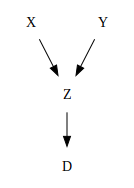

In [8]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")
g.node("D")

g.edge("X", "Z")
g.edge("Y", "Z")
g.edge("Z", "D")
g

### 6E4
How is a biased sample like conditioning on a collider?
Think of the example at the opening of the chapter.

---

Conditioning on a collider is like restricting attention to the subsample where the collider takes a particular value.
If the values of the collider are affected by the other two variables, then this is equivalent to selecting for certain (joint) values of those variables.
This is equivalent to selecting a biased (sub)sample.

## Medium

### 6M1
Modify the DAG on page 186 to include the variable $V$, an unobserved cause of $C$ and $Y$: $C \leftarrow V \rightarrow Y$.
Reanalyze the DAG.
How many paths connect $X$ to $Y$?
Which must be closed?
Which variables should you condition on now?

---

Let's redraw the DAG.

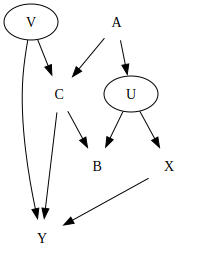

In [9]:
g = gr.Digraph("6m1", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("U", color="black")
g.node("V", color="black")
g.node("A")
g.node("B")
g.node("C")

g.edge("X", "Y")
g.edge("U", "X")
g.edge("A", "U")
g.edge("A", "C")
g.edge("U", "B")
g.edge("C", "B")
g.edge("C", "Y")
g.edge("V", "C")
g.edge("V", "Y")
g

There are now five paths connecting $X$ and $Y$:
1. $X \rightarrow Y$
2. $X \leftarrow U \leftarrow A \rightarrow C \rightarrow Y$
3. $X \leftarrow U \rightarrow B \leftarrow C \rightarrow Y$
2. $X \leftarrow U \leftarrow A \rightarrow C \leftarrow V \rightarrow Y$
3. $X \leftarrow U \rightarrow B \leftarrow C \leftarrow V \rightarrow Y$

Paths 2, and 4 are open and so must be closed.
The others are closed since they contain the confound at $B$.

We can close all open paths by conditioning on $A$.

### 6M2
Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model.
This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model.
To highlight this, consider the DAG $X \to Z \to Y$.
Simulate data from this DAG so that the correlation between $X$ and $Z$ is very large.
Then include both in a model predicting $Y$.
Do you observe any multicollinearity?
Why or why not?
What is different from the legs example in the chapter?

---

Let's simulate some data

In [10]:
N = 100

rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(loc=0, scale=1, size=N)
z = 1 + 2 * x + rng.normal(loc=0, scale=0.5, size=N)
y = 2 - z + rng.normal(loc=0, scale=0.5, size=N)

data = pd.DataFrame({"x": x, "y": y, "z": z})

There is a lot of correlation between the variables

In [11]:
data.corr()

,x,y,z
x,1.000000,-0.915949,0.956554
y,-0.915949,1.000000,-0.956216
z,0.956554,-0.956216,1.000000


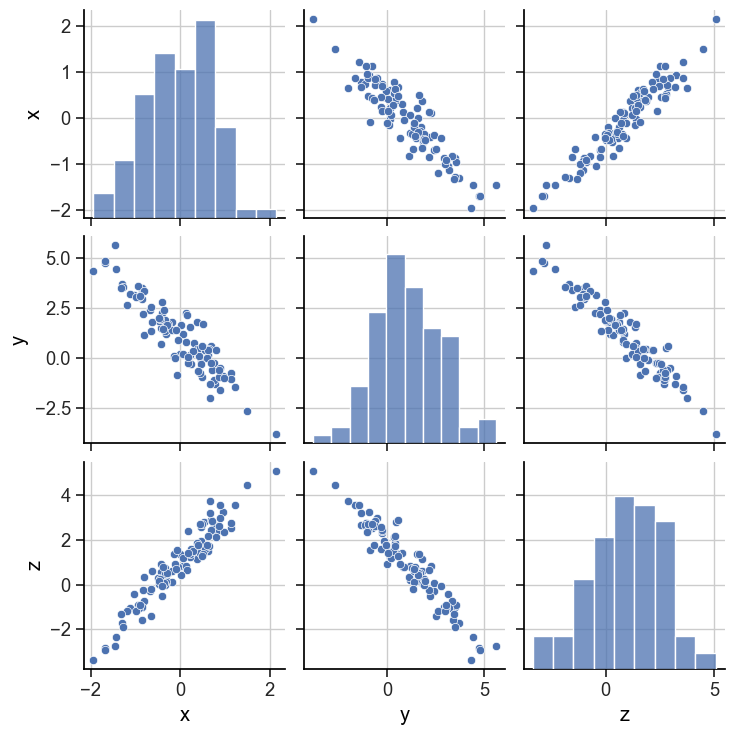

In [12]:
sns.pairplot(data);

Now we'll fit models for $Z$ as functions $X$ and $Y$ separately and together.
I can't be bothered to normalise everything so I'll just use vague priors.

In [13]:
coords = {
    "obs_id": data.index,
}
with pm.Model(coords_mutable=coords) as m_6m2a:
    # data
    x = pm.MutableData("x", data.x, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_x = pm.Normal("beta_x", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_x * x, dims="obs_id")

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")

    # sample
    trace_6m2a = pm.sample(random_seed=RANDOM_SEED)


with pm.Model(coords_mutable=coords) as m_6m2b:
    # data
    z = pm.MutableData("z", data.z, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_z = pm.Normal("beta_z", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_z * z, dims="obs_id")

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")

    # sample
    trace_6m2b = pm.sample(random_seed=RANDOM_SEED)


with pm.Model(coords_mutable=coords) as m_6m2c:
    # data
    x = pm.MutableData("x", data.x, dims="obs_id")
    z = pm.MutableData("z", data.z, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_x = pm.Normal("beta_x", mu=0, sigma=2)
    beta_z = pm.Normal("beta_z", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_x * x + beta_z * z, dims="obs_id")

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")

    # sample
    trace_6m2c = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, beta_z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Now look at the results.

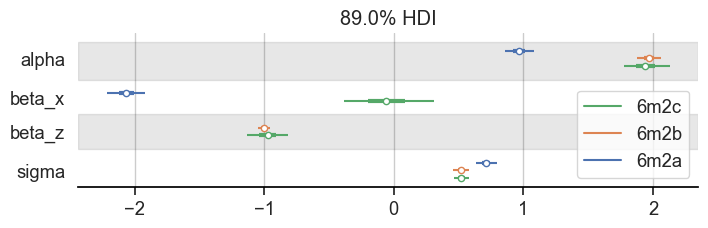

In [14]:
fig, ax = plt.subplots(figsize=(8, 2))

az.plot_forest(
    [trace_6m2a, trace_6m2b, trace_6m2c],
    model_names=["6m2a", "6m2b", "6m2c"],
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The book defined multicollinearity as follows: each individual predictor helps in predicting the outcome, but neither helps as much once you know the other.
That's not what's happening here.
If we have $Z$ in the model, then adding $X$ appears to increase uncertainty in the posteriors (this is a bit of a mirage - there is a lot of correlation in the posteriors) but it doesn't meaningfully change the estimate of $\beta_Z$.
That is, $Z$ is independent of $Y$ conditional on $X$.
This wasn't the case in the legs example, where there was no direct causal relationship between the two predictors.

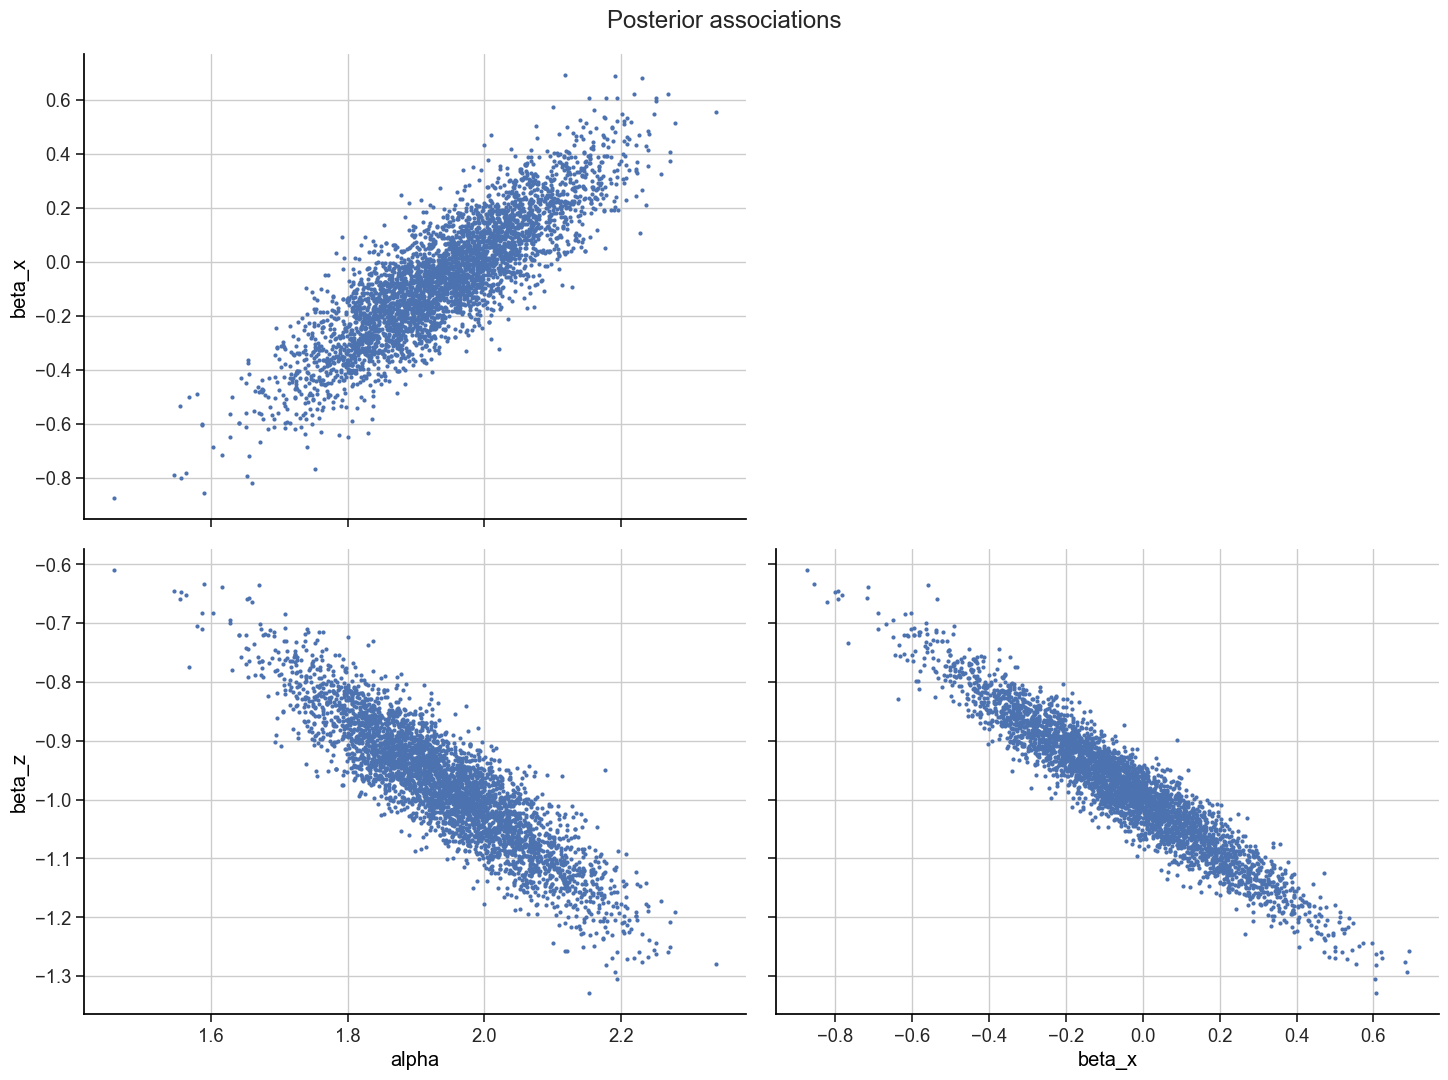

In [15]:
axs = az.plot_pair(
    trace_6m2c,
    var_names=["alpha", "beta_x", "beta_z"],
)
fig = axs[0][0].get_figure()
fig.suptitle("Posterior associations")
fig.tight_layout();

### 6M3
Learning to analyze DAGs requires practice.
For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of $X$ on $Y$.

---

a) Conditioning on $Z$ takes care of both open paths.

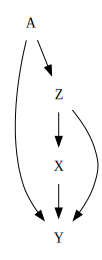

In [16]:
g = gr.Digraph("6m3a", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("Z", "X")
g.edge("Z", "Y")
g.edge("A", "Z")
g.edge("A", "Y")
g

b) There are two additional paths from $X$ to $Y$, but only the one through $A$ is a backdoor.
But, since $Z$ is a collider this path is already closed.
So we don't need to condition on anything.

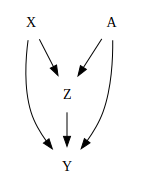

In [17]:
g = gr.Digraph("6m3b", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Z", "Y")
g.edge("A", "Z")
g.edge("A", "Y")
g

c) There are two additional paths from $X$ to $Y$, but only the one through $A$ is a backdoor path.
But, this path is already closed because $Z$ is a collider.
So we don't need to condition on any variables.

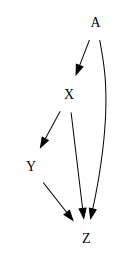

In [18]:
g = gr.Digraph("6m3c", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Y", "Z")
g.edge("A", "X")
g.edge("A", "Z")
g

d) Everything is the same as in (c), except $Z$ is no longer a collider.
So we need to close the path through $A$ by conditioning on $A$.

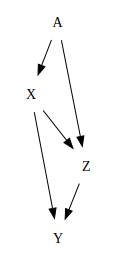

In [19]:
g = gr.Digraph("6m3d", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Z", "Y")
g.edge("A", "X")
g.edge("A", "Z")
g

## Hard

### 6H1
Use the Waffle House data, `data(WaffleDivorce)`, to find the total causal influence of number of Waffle Houses on divorce rate.
Justify your model or models with a causal graph.

---

We have seen previously that median marriage age $A$ has a causal effect on marriage rate $M$ and divorce rate $D$ but that $M$ is independent of $D$ conditional on $A$.
I hypothesise that Southernness $S$ has a causal effect on the number of Wafflehouses $W$, $A$, and $M$, but not $D$.
This yields the following DAG:

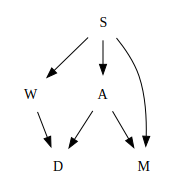

In [20]:
g = gr.Digraph("6h1a", node_attr={"color": "white"})

g.node("W")
g.node("S")
g.node("M")
g.node("A")
g.node("D")

g.edge("W", "D")
g.edge("S", "W")
g.edge("S", "M")
g.edge("S", "A")
g.edge("A", "M")
g.edge("A", "D")
g

There are two backdoor paths.
Since $M$ is a collider, the path through it already closed so we only need to close the other path.
We can do this by conditioning on either $S$ or $A$, but conditioning on $A$ should improve the estimate of $W \to D$.

Start by reloading the data.

In [21]:
# load data
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# rename columns
waffle = waffle.rename(
    columns={
        "Divorce": "divorce",
        "Marriage": "marriage",
        "MedianAgeMarriage": "age",
        "WaffleHouses": "wafflehouse",
        "South": "south",
    }
)

waffle["wafflehouse"] = waffle["wafflehouse"].astype(float)

waffle["north_south"] = np.where(
    waffle["south"] == 0,
    "north",
    "south",
)


# normalise columns
def normalise(data):
    return (data - data.mean()) / data.std()


for col in ["divorce", "marriage", "age", "wafflehouse"]:
    waffle[f"{col}_norm"] = normalise(waffle[col])

#### Regression on $A$

Now fit a model on $W$ and $A$.

In [22]:
coords = {
    "state": waffle.Location,
}
with pm.Model(coords_mutable=coords) as m_6h1a:
    # data
    wafflehouse = pm.MutableData("wafflehouse", waffle.wafflehouse, dims="state")
    age = pm.MutableData("age", waffle.age, dims="state")

    # normalise
    wafflehouse_norm = pm.Deterministic(
        "wafflehouse_norm",
        (wafflehouse - waffle.wafflehouse.mean()) / waffle.wafflehouse.std(),
        dims="state",
    )
    age_norm = pm.Deterministic(
        "age_norm",
        (age - waffle.age.mean()) / waffle.age.std(),
        dims="state",
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm",
        alpha + beta_age * age_norm + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu_norm,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # unnormalise
    mu = pm.Deterministic(
        "mu",
        mu_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )
    divorce = pm.Deterministic(
        "divorce",
        divorce_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )

    # sample
    trace_6h1a = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


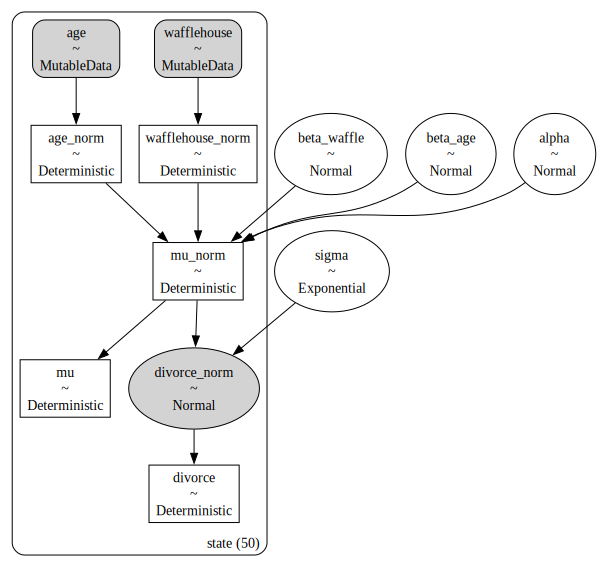

In [23]:
m_6h1a.to_graphviz()

Let's look at the coefficients.

In [24]:
az.summary(
    trace_6h1a,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="like",
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.000,0.099,-0.160,0.157
beta_age,-0.572,0.116,-0.773,-0.407
beta_waffle,0.185,0.117,0.000,0.374
sigma,0.810,0.087,0.669,0.941


This gives an estimate of 0.185 for the coefficient of $W$.
Let's relate that back to real numbers.

In [25]:
beta_waffle_mean = trace_6h1a.posterior.beta_waffle.mean().item()
(beta_waffle_mean / waffle["wafflehouse"].std() * waffle["divorce"].std()).round(4)

0.0051

So an increase of 100 Waffle House per million implies an increase of half a percent in the divorce rate.

It's difficult to plot the results of this multiple regression, but we can make an attempt by putting age into three bins.

In [26]:
waffle["age_bin"] = pd.cut(waffle["age"], bins=3, retbins=False)
age_vals = waffle.groupby("age_bin").age.mean().values

N = 100
wafflehouse_vals = np.linspace(
    waffle.wafflehouse.min(),
    waffle.wafflehouse.max(),
    N,
)

with m_6h1a:
    counterfact_trace_dict_6h1a = {}
    for age in age_vals:
        pm.set_data(
            {
                "age": np.full(N, age),
                "wafflehouse": wafflehouse_vals,
            },
            coords={"state": range(N)},
        )
        counterfact_trace_dict_6h1a[age] = pm.sample_posterior_predictive(
            trace_6h1a,
            var_names=["mu", "divorce"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


In [27]:
def plot_divorce_counterfactuals(trace, color=None, hdi_prob=0.89, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 6))

    wafflehouse = trace.predictions_constant_data.wafflehouse

    mu_mean = trace.predictions.mu.mean(dim=["chain", "draw"])
    ax.plot(wafflehouse, mu_mean, color=color)

    mu_hdi = az.hdi(trace.predictions.mu, hdi_prob=hdi_prob).mu
    ax.fill_between(
        wafflehouse,
        mu_hdi.sel(hdi="lower"),
        mu_hdi.sel(hdi="higher"),
        color=color,
        alpha=0.3,
    )

    divorce_hdi = az.hdi(trace.predictions.divorce, hdi_prob=hdi_prob).divorce
    ax.fill_between(
        wafflehouse,
        divorce_hdi.sel(hdi="lower"),
        divorce_hdi.sel(hdi="higher"),
        color=color,
        alpha=0.1,
    )

    return ax

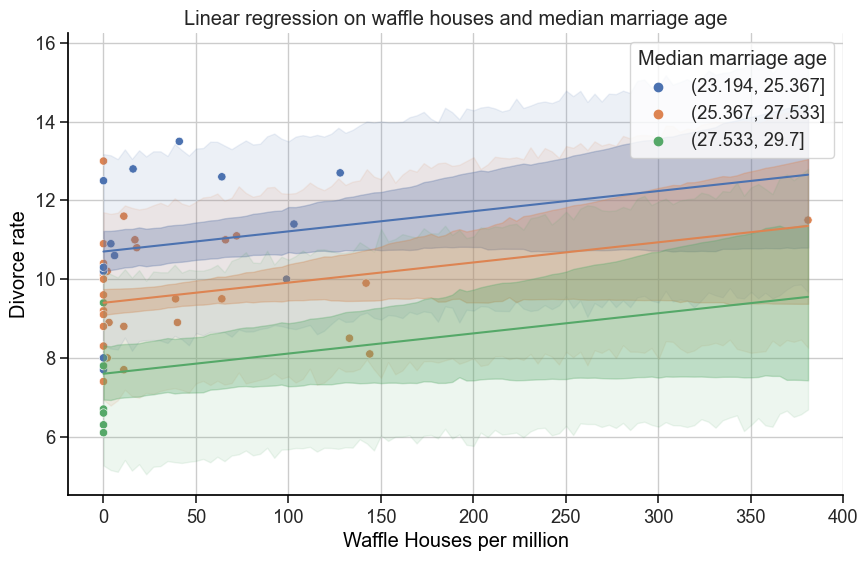

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot actual data
sns.scatterplot(
    data=waffle,
    x="wafflehouse",
    y="divorce",
    hue="age_bin",
    ax=ax,
)

for color, (_, trace) in zip(colors, counterfact_trace_dict_6h1a.items()):
    plot_divorce_counterfactuals(trace, color=color, ax=ax)

ax.set(
    xlabel="Waffle Houses per million",
    ylabel="Divorce rate",
    title="Linear regression on waffle houses and median marriage age",
)
ax.legend(title="Median marriage age");

It's not a terribly convincing graph.

#### Regression on $S$

Theoretically, conditioning on $S$ should give us (roughly) the same estimate.
Let's test that out.

In [29]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h1b:
    # data
    wafflehouse = pm.MutableData("wafflehouse", waffle.wafflehouse, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # normalise
    wafflehouse_norm = pm.Deterministic(
        "wafflehouse_norm",
        (wafflehouse - waffle.wafflehouse.mean()) / waffle.wafflehouse.std(),
        dims="state",
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm", alpha[south_idx] + beta_waffle * wafflehouse_norm, dims="state"
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu_norm,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # unnormalise
    mu = pm.Deterministic(
        "mu",
        mu_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )
    divorce = pm.Deterministic(
        "divorce",
        divorce_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )

    # sample
    trace_6h1b = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


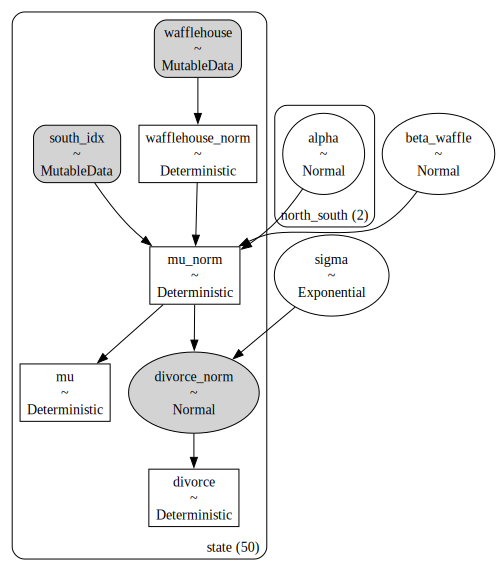

In [30]:
m_6h1b.to_graphviz()

Let's look at the coefficients.

In [31]:
az.summary(
    trace_6h1b,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="like",
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[north],-0.080,0.134,-0.297,0.131
alpha[south],0.129,0.174,-0.130,0.421
beta_waffle,0.189,0.154,-0.046,0.443
sigma,0.976,0.101,0.819,1.137


The estimate of the waffle coefficient is similar to before, but with a wider posterior.
This fits with what we said at the start of the exercise: conditioning on $A$ should give the same effect as conditioning on $S$, but should lead to a more precise estimate of the causal effect of $W$.

The advantage of this model is that it also deals with the DAG where there is also a direct causal effect $S \to D$.

Now that the conditioned variable is binary, the posteriors are much easier to plot.

First we'll need to generate counterfactual values for both the north and the south.

In [32]:
N = 100

wafflehouse_vals = np.linspace(
    waffle.wafflehouse.min(),
    waffle.wafflehouse.max(),
    N,
)

with m_6h1b:
    # southern data
    pm.set_data(
        {
            "south_idx": np.ones(N).astype(int),
            "wafflehouse": wafflehouse_vals,
        },
        coords={"state": range(N)},
    )
    counterfact_south_trace_6h1b = pm.sample_posterior_predictive(
        trace_6h1b,
        var_names=["mu", "divorce"],
        predictions=True,
        random_seed=RANDOM_SEED,
    )

    # northern data
    pm.set_data(
        {
            "south_idx": np.zeros(N).astype(int),
            "wafflehouse": wafflehouse_vals,
        },
        coords={"state": range(N)},
    )
    counterfact_north_trace_6h1b = pm.sample_posterior_predictive(
        trace_6h1b,
        var_names=["mu", "divorce"],
        predictions=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [divorce_norm]


Sampling: [divorce_norm]


Now let's plot it

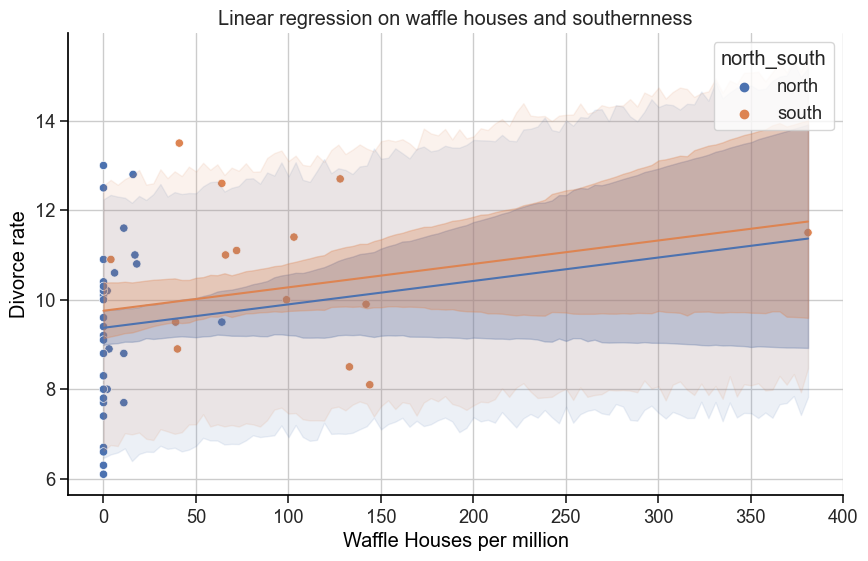

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot actual data
sns.scatterplot(
    data=waffle,
    x="wafflehouse",
    y="divorce",
    hue="north_south",
    hue_order=["north", "south"],
    ax=ax,
)

plot_divorce_counterfactuals(counterfact_north_trace_6h1b, color=colors[0], ax=ax)
plot_divorce_counterfactuals(counterfact_south_trace_6h1b, color=colors[1], ax=ax)

ax.set(
    xlabel="Waffle Houses per million",
    ylabel="Divorce rate",
    title="Linear regression on waffle houses and southernness",
);

This looks roughly similar to the last graph.
It's still not terribly convincing.

#### Interaction between $A$ and $S$

Finally, in exercise 5H4 we found that divorce rate was best modelled using an interaction term between Southernness and age (without $S$ on its own).

If we let $I$ denote the interaction term between $S$ and $A$, and use a dashed line to indicate that the relationship is deterministic, then the updated DAG is as follows:

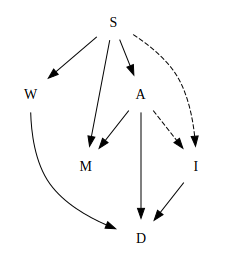

In [34]:
g = gr.Digraph("6h1b", node_attr={"color": "white"})

g.node("W")
g.node("S")
g.node("M")
g.node("A")
g.node("D")
g.node("I")

g.edge("W", "D")
g.edge("S", "W")
g.edge("S", "M")
g.edge("S", "A")
g.edge("S", "I", style="dashed")
g.edge("A", "M")
g.edge("A", "D")
g.edge("A", "I", style="dashed")
g.edge("I", "D")
g

This means that we could either condition on $S$ or on $A$ and $I$.
We have already tried conditioning just on $S$, so let's try conditioning on $A$ and $I$.
This has the additional benefits that:
- It should produce more accurate estimates
- It will help me verify my understanding that my understanding of interactions in DAGs is correct

First define the model - this is just the same as in 5H4.

In [35]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h1c:
    # data
    wafflehouse = pm.MutableData("wafflehouse", waffle.wafflehouse, dims="state")
    age = pm.MutableData("age", waffle.age, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # normalise
    wafflehouse_norm = pm.Deterministic(
        "wafflehouse_norm",
        (wafflehouse - waffle.wafflehouse.mean()) / waffle.wafflehouse.std(),
        dims="state",
    )
    age_norm = pm.Deterministic(
        "age_norm",
        (age - waffle.age.mean()) / waffle.age.std(),
        dims="state",
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5, dims="north_south")
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm",
        alpha + beta_age[south_idx] * age_norm + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    # divorce_norm = pm.Normal(
    #     "divorce_norm",
    #     mu=mu_norm,
    #     sigma=sigma,
    #     observed=waffle.divorce_norm,
    #     dims="state",
    # )
    divorce_norm = pm.StudentT(
        "divorce_norm",
        mu=mu_norm,
        sigma=sigma,
        nu=1,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # unnormalise
    mu = pm.Deterministic(
        "mu",
        mu_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )
    divorce = pm.Deterministic(
        "divorce",
        divorce_norm * waffle.divorce.std() + waffle.divorce.mean(),
        dims="state",
    )

    # sample
    trace_6h1c = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


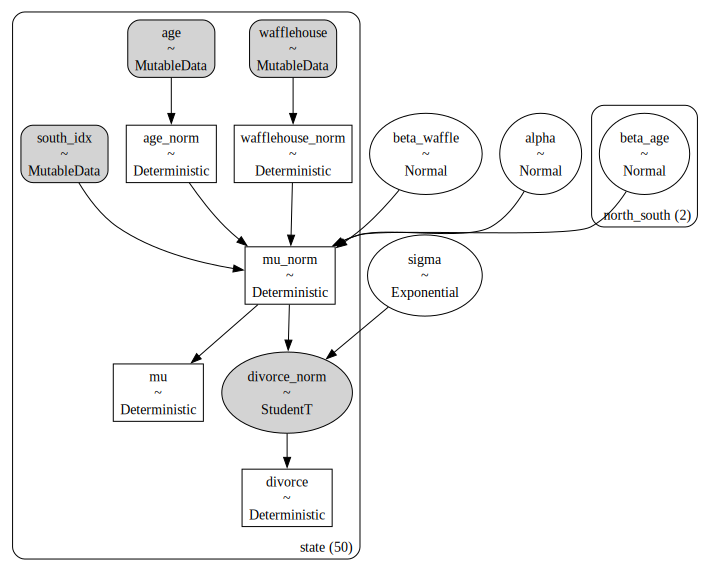

In [36]:
m_6h1c.to_graphviz()

In [37]:
az.summary(
    trace_6h1c,
    var_names=["alpha", "beta", "sigma"],
    filter_vars="like",
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.074,0.106,-0.232,0.106
beta_age[north],-0.601,0.139,-0.818,-0.381
beta_age[south],-1.412,0.268,-1.807,-0.961
beta_waffle,0.114,0.118,-0.080,0.285
sigma,0.459,0.084,0.319,0.584


Let's compare the models

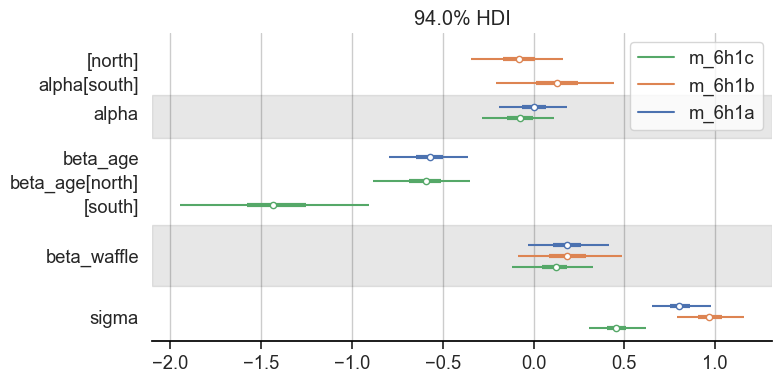

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))

az.plot_forest(
    [trace_6h1a, trace_6h1b, trace_6h1c],
    model_names=["m_6h1a", "m_6h1b", "m_6h1c"],
    var_names=["alpha", "beta", "sigma"],
    filter_vars="like",
    combined=True,
    ax=ax,
);

This does give us a similar, though slightly more precise, estimate for the coefficient of `waffle`.
This confirms our earlier claim - if we're only interested in the causal effect of Wafflehouses on divorce rates, it should be sufficient to control for $S$.

Finally I want to visualise the relationship between number of wafflehouses and divorce rates.
Now we have to stratify both age and Southernness.
I think the best way to do this is to bin age and generate counterfactuals for both North and South using the mean in each bin.
I'll then plot North and South on adjacent axes and plot separate lines for each age bin.

Below I'm using age bins that provide a reasonable stratification of age for both North and South.

In [39]:
N = 100
age_bins = [0, 25.0, 25.7, 26.8, 100]

waffle["age_bin"] = pd.cut(waffle["age"], bins=age_bins, retbins=False)
mean_ages = waffle.groupby("age_bin").age.mean()
age_bins = waffle["age_bin"].sort_values().unique()

# identify bins represented in north and south
north_age_bins = (
    waffle.loc[
        waffle["north_south"] == "north",
        "age_bin",
    ]
    .sort_values()
    .unique()
)
south_age_bins = (
    waffle.loc[
        waffle["north_south"] == "south",
        "age_bin",
    ]
    .sort_values()
    .unique()
)

wafflehouse_vals = np.linspace(
    waffle.wafflehouse.min(),
    waffle.wafflehouse.max(),
    N,
)

with m_6h1c:
    # generate counterfactuals for each age bin in the north
    counterfact_north_trace_dict_6h1c = dict.fromkeys(mean_ages)
    for age_bin in north_age_bins:
        mean_age = mean_ages.loc[age_bin]
        pm.set_data(
            {
                "age": np.full(N, mean_age),
                "south_idx": np.zeros(N).astype(int),
                "wafflehouse": wafflehouse_vals,
            },
            coords={"state": range(N)},
        )
        counterfact_north_trace_dict_6h1c[mean_age] = pm.sample_posterior_predictive(
            trace_6h1c,
            var_names=["mu", "divorce"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    # ...and in the south
    counterfact_south_trace_dict_6h1c = dict.fromkeys(mean_ages)
    for age_bin in south_age_bins:
        mean_age = mean_ages.loc[age_bin]
        pm.set_data(
            {
                "age": np.full(N, mean_age),
                "south_idx": np.ones(N).astype(int),
                "wafflehouse": wafflehouse_vals,
            },
            coords={"state": range(N)},
        )
        counterfact_south_trace_dict_6h1c[mean_age] = pm.sample_posterior_predictive(
            trace_6h1c,
            var_names=["mu", "divorce"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


Sampling: [divorce_norm]


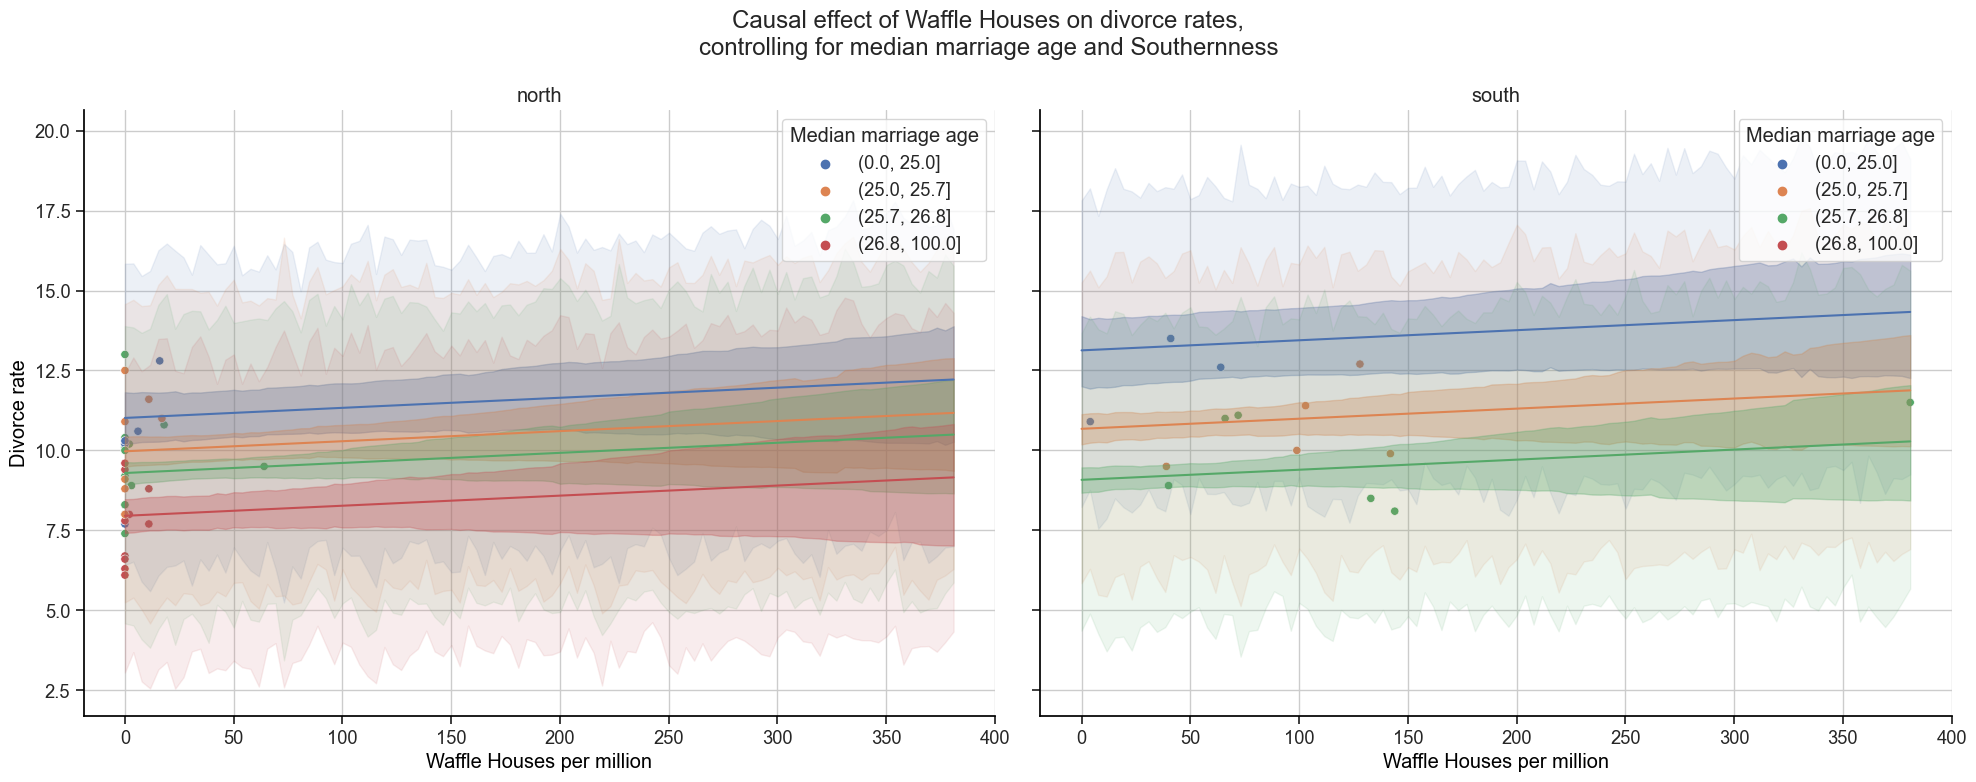

In [40]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(20, 8))

# plot actual data (south)
for ax, north_south_val, counterfact_trace_dict in zip(
    axs,
    ["north", "south"],
    [counterfact_north_trace_dict_6h1c, counterfact_south_trace_dict_6h1c],
):
    sns.scatterplot(
        data=waffle[waffle["north_south"] == north_south_val],
        x="wafflehouse",
        y="divorce",
        hue="age_bin",
        ax=ax,
    )

    for color, trace in zip(colors, counterfact_trace_dict.values()):
        if trace is not None:
            plot_divorce_counterfactuals(trace, color=color, ax=ax)

    ax.set(
        # xscale="log",
        xlabel="Waffle Houses per million",
        ylabel="Divorce rate",
        title=north_south_val,
    )
    ax.legend(title="Median marriage age")


fig.suptitle(
    "Causal effect of Waffle Houses on divorce rates,\ncontrolling for median marriage age and Southernness"
)
fig.tight_layout();

I think this is a better model that in that more of the variance is explained, but it doesn't change our conclusions when it comes to the causal effect of Wafflehouses.

But, notice that for Northern states the greatest number of Waffle houses is only around 60 million.
Let's adjust the x-axes to reflect that.

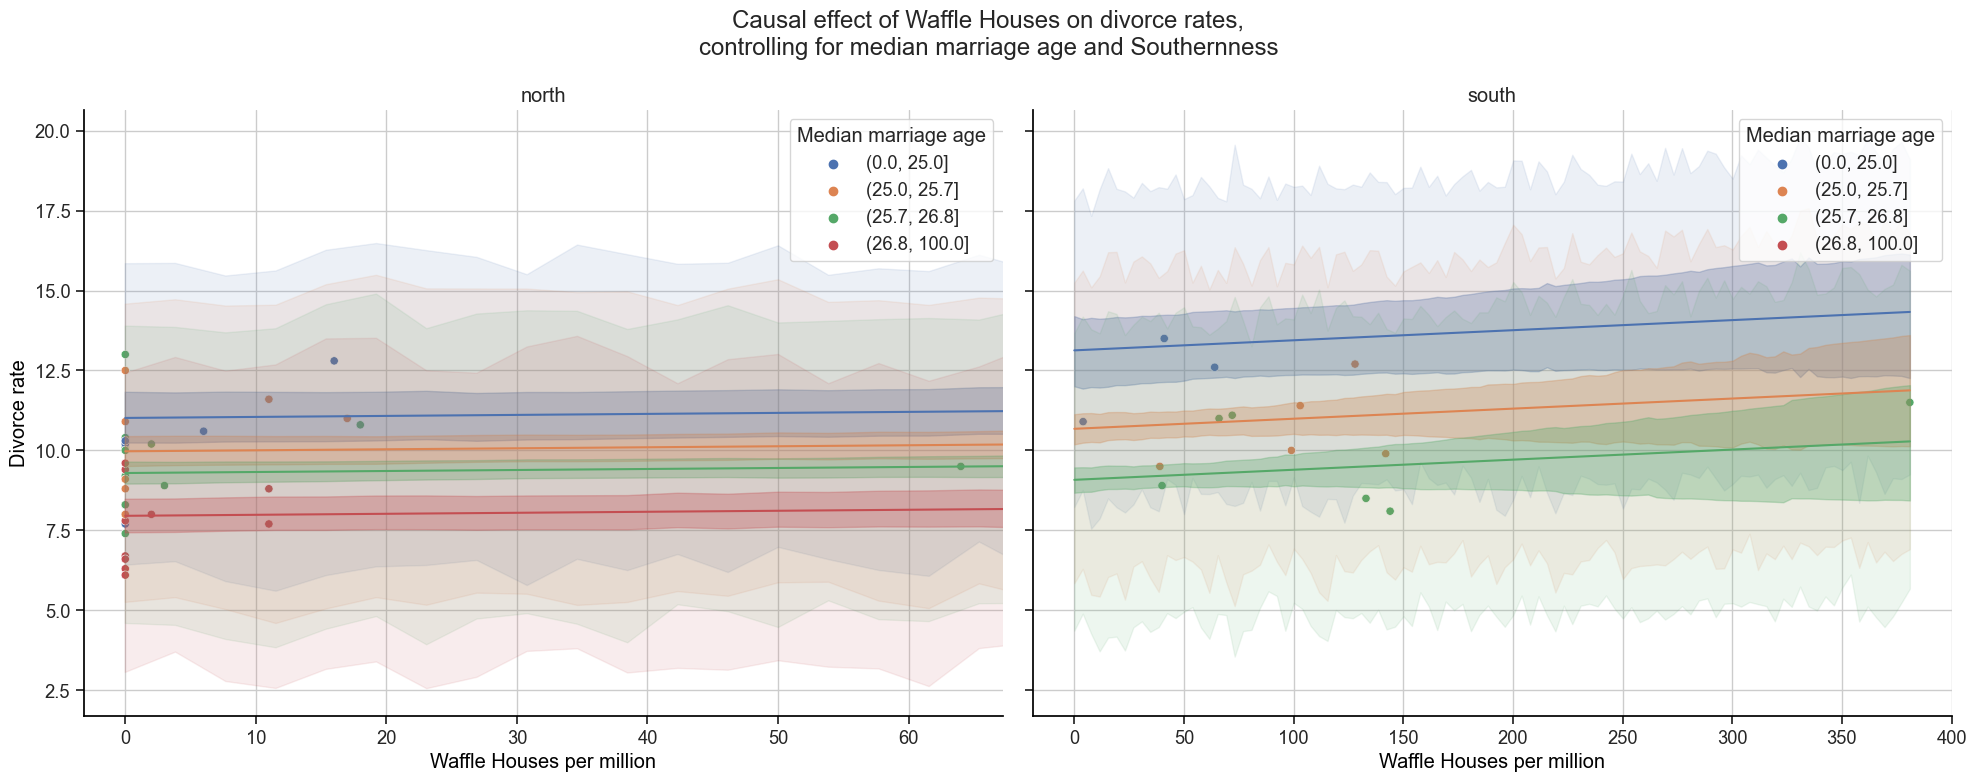

In [41]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(20, 8))

# plot actual data (south)
for ax, north_south_val, counterfact_trace_dict in zip(
    axs,
    ["north", "south"],
    [counterfact_north_trace_dict_6h1c, counterfact_south_trace_dict_6h1c],
):
    sns.scatterplot(
        data=waffle[waffle["north_south"] == north_south_val],
        x="wafflehouse",
        y="divorce",
        hue="age_bin",
        ax=ax,
    )

    for color, trace in zip(colors, counterfact_trace_dict.values()):
        if trace is not None:
            plot_divorce_counterfactuals(trace, color=color, ax=ax)

    # adjust the x limits
    xmin = 0
    xmax = waffle.loc[waffle["north_south"] == north_south_val, "wafflehouse"].max()
    xrange = xmax - xmin

    xmin -= 0.05 * xrange
    xmax += 0.05 * xrange

    # set plot params
    ax.set(
        xlim=[xmin, xmax],
        xlabel="Waffle Houses per million",
        ylabel="Divorce rate",
        title=north_south_val,
    )
    ax.legend(title="Median marriage age")


fig.suptitle(
    "Causal effect of Waffle Houses on divorce rates,\ncontrolling for median marriage age and Southernness"
)
fig.tight_layout();

Now it's clear that the causal effect of Wafflehouses is effectively meaningless on the scale of Northern states, so I doubt they are having much impact on the learned slope.
That is, the learned slope is coming almost entirely from the Southern states.

That does concern me a bit - this slope could be coming from just a few points.
Let's check this using an information criterion.

In [42]:
models = {
    "m_6h1a": trace_6h1a,
    "m_6h1b": trace_6h1b,
    "m_6h1c": trace_6h1c,
}
az.compare(models, ic="waic", scale="deviance")

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_6h1a,0,124.902367,4.317751,0.000000,8.869055e-01,12.770265,0.000000,True,deviance
m_6h1c,1,135.437601,6.149850,10.535234,2.130238e-14,10.317727,7.669038,True,deviance
m_6h1b,2,141.164921,2.103167,16.262554,1.130945e-01,8.574881,11.709103,False,deviance


We get some warnings so let's plot the individual values.

In [43]:
psis_6h1c = az.loo(trace_6h1c, scale="deviance", pointwise=True)
waic_6h1c = az.waic(trace_6h1c, scale="deviance", pointwise=True)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


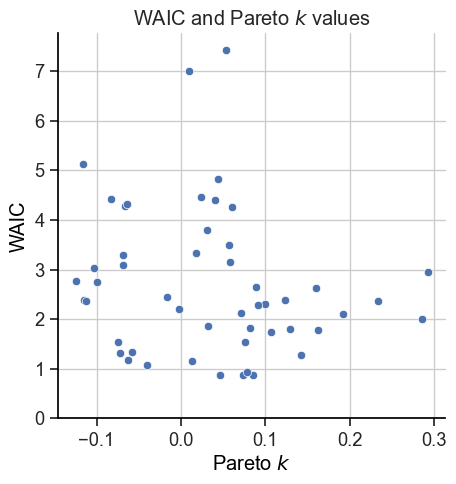

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    x=psis_6h1c.pareto_k,
    y=waic_6h1c.waic_i,
    ax=ax,
)

ax.set(
    ylim=[0, ax.get_ylim()[1]],
    xlabel="Pareto $k$",
    ylabel="WAIC",
    title="WAIC and Pareto $k$ values",
);

There are two very important points.
Which states are these?

In [45]:
waic_6h1c.waic_i.sortby(waic_6h1c.waic_i, ascending=False).isel(state=slice(2))

<xarray.DataArray 'waic_i' (state: 2)>
array([7.43755384, 7.00561073])
Coordinates:
  * state    (state) <U20 'Idaho' 'Maine'

Okay, so these aren't actually Southern.
In fact they have no wafflehouses.

Looking at the information criteria doesn't support my worry that one or two Southern states with lots of Wafflehouses are have a large impact on the model fit.

#### Conclusion

I estimate that Wafflehouses have a small positive effect on the divorce rate, such that an increase of 100 Wafflehouses per million causes an increase in the divorce rate of around 0.5%.
However, there is enough variance in the posterior that the effect could reasonably non-existent, particularly since it seems to be dependent on quite a small number of points.

### 6H2
Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem.
If any of the tests fail, how do you think the graph needs to be amended?
Does the graph need more or fewer arrows?
Feel free to nominate variables that aren't in the data.

---

I'll use the original graph:

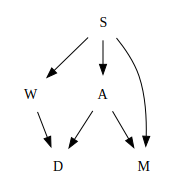

In [46]:
g = gr.Digraph("6h2", node_attr={"color": "white"})

g.node("W")
g.node("S")
g.node("M")
g.node("A")
g.node("D")

g.edge("W", "D")
g.edge("S", "W")
g.edge("S", "M")
g.edge("S", "A")
g.edge("A", "M")
g.edge("A", "D")
g

The conditional independencies of the graph are as follows:
1. $W$ is independent of $A$, conditional on $S$
2. $W$ is independent of $M$, conditional on $S$
3. $D$ is independent of $S$, conditional on $A$ and $W$
4. $D$ is independent of $M$, conditional on $A$ and $W$
5. $D$ is independent of $M$, conditional on $A$ and $S$

To test these we build models with the given exposure and outcome.
If a given conditional independency is true, then adding the conditioning variables to the model should lead to the coefficient of the exposure to be 0.

#### $W$ is independent of $A$, conditional on $S$

If this conditional independence were false, we would expect the causal effect to go $W \to A$, so I will regress $A$ on $W$.
I'll start with a model without $S$, then add it in and see how it affects inference.
For convenience I'm just going to work with normed values the whole way through.

In [47]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h2ai:
    # data
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    age_norm = pm.Normal(
        "age_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.age_norm,
        dims="state",
    )

    # sample
    trace_6h2ai = pm.sample(
        random_seed=RANDOM_SEED,
    )


with pm.Model(coords_mutable=coords) as m_6h2aii:
    # data
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[south_idx] + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    age_norm = pm.Normal(
        "age_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.age_norm,
        dims="state",
    )

    # sample
    trace_6h2aii = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now let's compare the mdoels.

In [48]:
az.summary(
    trace_6h2ai,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.12,-0.18,0.18,0.0,0.0,5253.64,3152.39,1.0
beta_waffle,-0.11,0.15,-0.35,0.11,0.0,0.0,5143.75,3166.22,1.0
sigma,1.02,0.11,0.86,1.18,0.0,0.0,4917.99,2517.51,1.0


In [49]:
az.summary(
    trace_6h2aii,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[north],0.08,0.13,-0.14,0.29,0.0,0.0,3777.04,3132.65,1.0
alpha[south],-0.12,0.17,-0.41,0.14,0.0,0.0,3369.34,3248.79,1.0
beta_waffle,-0.06,0.16,-0.32,0.18,0.0,0.0,3203.12,3195.89,1.0
sigma,1.00,0.11,0.83,1.16,0.0,0.0,4959.33,3258.88,1.0


It's easier with a plot

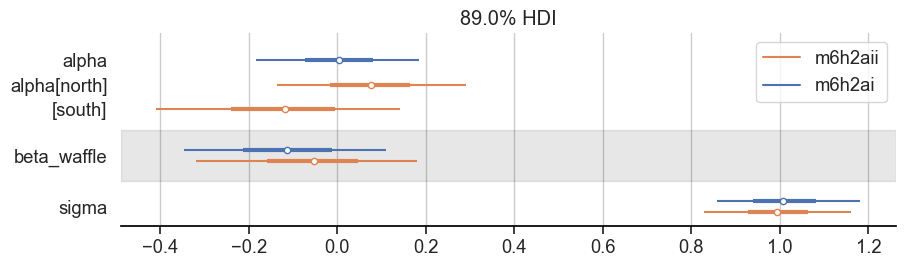

In [50]:
models_6h2a = {
    "m6h2ai": trace_6h2ai,
    "m6h2aii": trace_6h2aii,
}

fig, ax = plt.subplots(figsize=(10, 2.5))

az.plot_forest(
    list(models_6h2a.values()),
    model_names=list(models_6h2a.keys()),
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

Adding Southernness to the model has moved the Wafflehouse coefficient closer to zero - it is now comfortably within the interquartile range of the posterior.
This doesn't give much evidence against the claim that $W$ and $A$ are conditionally independent given $S$.

#### $W$ is independent of $M$, conditional on $S$

Again, if this conditional independence were false, we would expect the causal effect to go $W \to M$, so I will regress $M$ on $W$.

In [51]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h2bi:
    # data
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    marriage_norm = pm.Normal(
        "marriage_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.marriage_norm,
        dims="state",
    )

    # sample
    trace_6h2bi = pm.sample(
        random_seed=RANDOM_SEED,
    )


with pm.Model(coords_mutable=coords) as m_6h2bii:
    # data
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[south_idx] + beta_waffle * wafflehouse_norm,
        dims="state",
    )

    # likelihood
    marriage_norm = pm.Normal(
        "marriage_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.marriage_norm,
        dims="state",
    )

    # sample
    trace_6h2bii = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now let's compare the mdoels.

In [52]:
az.summary(
    trace_6h2bi,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.12,-0.18,0.20,0.0,0.0,5726.66,3118.10,1.0
beta_waffle,0.03,0.15,-0.20,0.27,0.0,0.0,4763.68,2613.41,1.0
sigma,1.02,0.10,0.85,1.18,0.0,0.0,6029.00,2939.20,1.0


In [53]:
az.summary(
    trace_6h2bii,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[north],-0.03,0.14,-0.25,0.18,0.0,0.0,3639.47,3060.76,1.0
alpha[south],0.05,0.18,-0.25,0.31,0.0,0.0,4023.09,3312.19,1.0
beta_waffle,0.00,0.16,-0.26,0.26,0.0,0.0,3345.84,2970.43,1.0
sigma,1.02,0.11,0.85,1.18,0.0,0.0,4655.81,2997.45,1.0


It's easier with a plot

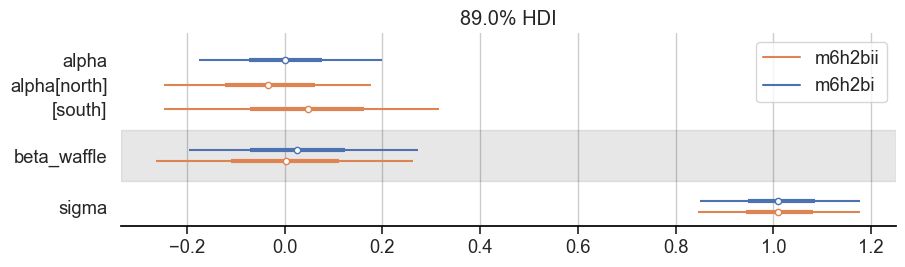

In [54]:
models_6h2b = {
    "m6h2bi": trace_6h2bi,
    "m6h2bii": trace_6h2bii,
}

fig, ax = plt.subplots(figsize=(10, 2.5))

az.plot_forest(
    list(models_6h2b.values()),
    model_names=list(models_6h2b.keys()),
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The posterior for the Wafflehouse coefficient is perfectly centred on zero, so this certainly provides no evidence against the claim of conditional independence.

#### $D$ is independent of $S$, conditional on $A$ and $W$

If this conditional independence were false, we would expect the causal effect to go $S \to D$, so I will regress $D$ on $S$.

Since we encode Southernness using an index variable, I'll test the claim of conditional independence by looking at the difference in posteriors between the two intercepts: $\alpha[\text{south}] - \alpha[\text{north}]$.

In [55]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h2ci:
    # data
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[south_idx],
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # difference between intercepts
    alpha_diff = pm.Deterministic(
        "alpha_diff",
        alpha[1] - alpha[0],
    )

    # sample
    trace_6h2ci = pm.sample(
        random_seed=RANDOM_SEED,
    )


with pm.Model(coords_mutable=coords) as m_6h2cii:
    # data
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )
    age_norm = pm.MutableData("age_norm", waffle.age_norm, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[south_idx] + beta_waffle * wafflehouse_norm + beta_age * age_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # difference between intercepts
    alpha_diff = pm.Deterministic(
        "alpha_diff",
        alpha[1] - alpha[0],
    )

    # sample
    trace_6h2cii = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_waffle, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now let's compare the mdoels.

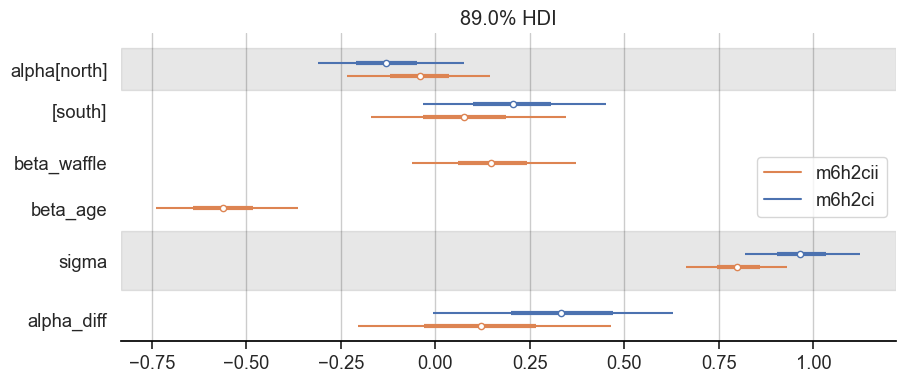

In [56]:
models_6h2c = {
    "m6h2ci": trace_6h2ci,
    "m6h2cii": trace_6h2cii,
}

fig, ax = plt.subplots(figsize=(10, 4))

az.plot_forest(
    list(models_6h2c.values()),
    model_names=list(models_6h2c.keys()),
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The posterior for the difference in North/South intercepts has moved considerably closer to 0 to the point where it lies within
the interquartile range.
I don't consider this sufficient evidence to reject the claim of conditional independence.

#### $D$ is independent of $M$, conditional on $A$ and $W$

If this conditional independence were false, we would expect the causal effect to go $M \to D$, so I will regress $D$ on $M$.

In [57]:
coords = {
    "state": waffle.Location,
}
with pm.Model(coords_mutable=coords) as m_6h2di:
    # data
    marriage_norm = pm.MutableData("marriage_norm", waffle.marriage_norm, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha + beta_marriage * marriage_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # sample
    trace_6h2di = pm.sample(
        random_seed=RANDOM_SEED,
    )


with pm.Model(coords_mutable=coords) as m_6h2dii:
    # data
    marriage_norm = pm.MutableData("marriage_norm", waffle.marriage_norm, dims="state")
    wafflehouse_norm = pm.MutableData(
        "wafflehouse_norm", waffle.wafflehouse_norm, dims="state"
    )
    age_norm = pm.MutableData("age_norm", waffle.age_norm, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=1.5)
    beta_waffle = pm.Normal("beta_waffle", mu=0, sigma=1.5)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha
        + beta_marriage * marriage_norm
        + beta_waffle * wafflehouse_norm
        + beta_age * age_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # sample
    trace_6h2dii = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, beta_waffle, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now let's compare the mdoels.

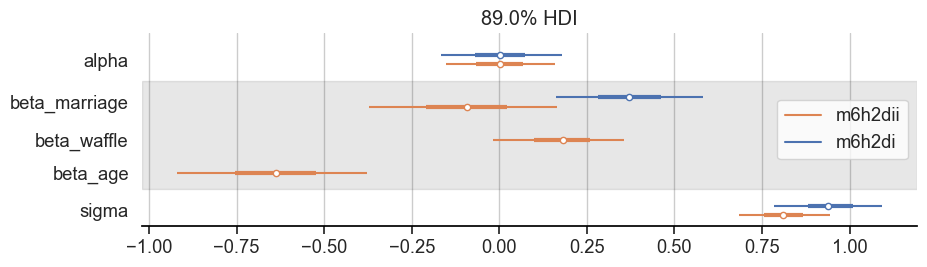

In [58]:
models_6h2d = {
    "m6h2di": trace_6h2di,
    "m6h2dii": trace_6h2dii,
}

fig, ax = plt.subplots(figsize=(10, 2.5))

az.plot_forest(
    list(models_6h2d.values()),
    model_names=list(models_6h2d.keys()),
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The posterior the coefficient of marriage is moved closer to zero by the inclusion of the confounders; after their inclusion 0 lies within the interquartile range.
I don't consider this sufficient evidence to seriously doubt the claim of conditional independence.

#### $D$ is independent of $M$, conditional on $A$ and $S$

Again, this conditional independence were false, we would expect the causal effect to go $M \to D$, so I will regress $D$ on $M$.

In [59]:
coords = {
    "state": waffle.Location,
    "north_south": ["north", "south"],
}
with pm.Model(coords_mutable=coords) as m_6h2ei:
    # data
    marriage_norm = pm.MutableData("marriage_norm", waffle.marriage_norm, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha + beta_marriage * marriage_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # sample
    trace_6h2ei = pm.sample(
        random_seed=RANDOM_SEED,
    )


with pm.Model(coords_mutable=coords) as m_6h2eii:
    # data
    marriage_norm = pm.MutableData("marriage_norm", waffle.marriage_norm, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")
    age_norm = pm.MutableData("age_norm", waffle.age_norm, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=1.5)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[south_idx] + beta_marriage * marriage_norm + beta_age * age_norm,
        dims="state",
    )

    # likelihood
    divorce_norm = pm.Normal(
        "divorce_norm",
        mu=mu,
        sigma=sigma,
        observed=waffle.divorce_norm,
        dims="state",
    )

    # sample
    trace_6h2eii = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_marriage, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now let's compare the mdoels.

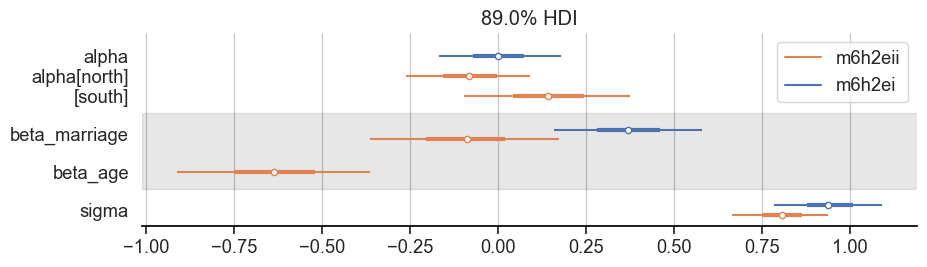

In [60]:
models_6h2e = {
    "m6h2ei": trace_6h2ei,
    "m6h2eii": trace_6h2eii,
}

fig, ax = plt.subplots(figsize=(10, 2.5))

az.plot_forest(
    list(models_6h2e.values()),
    model_names=list(models_6h2e.keys()),
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The posterior the coefficient of marriage is moved closer to zero by the inclusion of the confounders; after their inclusion 0 lies within the interquartile range.
I don't consider this sufficient evidence to seriously doubt the claim of conditional independence.

---

All three problems below are based on the same data.
The data in `data(foxes)` are 116 foxes from 30 different urban groups in England.
These foxes are like street gangs.
Group size varies from 2 to 8 individuals.
Each group maintains its own urban territory.
Some territories are larger than others.
The `area` variables encodes this information.
Some territories also have more `avgfood` than others.
We want to model the `weight` of each fox.
For the problems below, assume the following DAG:

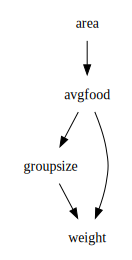

In [61]:
g = gr.Digraph("6hfox", node_attr={"color": "white"})

g.node("area")
g.node("avgfood")
g.node("groupsize")
g.node("weight")

g.edge("area", "avgfood")
g.edge("avgfood", "groupsize")
g.edge("avgfood", "weight")
g.edge("groupsize", "weight")
g

### 6H3

Use a model to infer the total causal influence of `area` on `weight`.
Would increasing the area available to each fox make it heavier (healthier)?
You might want to standardize the variables.
Regardless, use prior predictive simulation to show that your model's prior predictions stay within the possible outcome range.

---

In [62]:
# load data
foxes = load_data(FOXES_FILE, delimiter=",")

For data preparation I'll standardise the continuous variables to have mean zero and standard deviation one.
I won't rescale `groupsize` as a change of one is a meaningful value, but I will centre it at the median (4).

In [127]:
foxes["groupsize"] = foxes["groupsize"].astype(float)

# index variables need to start at 0
groups = np.sort(foxes["group"].unique())
foxes["group_idx"] = foxes["group"] - 1


# normalise columns
def normalise(data):
    return (data - data.mean()) / data.std()


for col in ["avgfood", "area", "weight"]:
    foxes[f"{col}_norm"] = normalise(foxes[col])

foxes["groupsize_norm"] = foxes["groupsize"] - foxes["groupsize"].median()

There are no backdoors from `area` to `weight` so we can estimate the causal influence by just regressing `weight` on `area`.

In [64]:
coords = {
    "obs_id": foxes.index,
}
with pm.Model(coords_mutable=coords) as m_6h3:
    # data
    area_norm = pm.MutableData("area_norm", foxes.area_norm, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_area = pm.Normal("beta_area", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_area * area_norm, dims="obs_id")

    # likelihood
    weight_norm = pm.Normal(
        "weight_norm", mu=mu, sigma=sigma, observed=foxes.weight_norm, dims="obs_id"
    )

    # hit the sample button
    prior_trace_6h3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta_area, sigma, weight_norm]


Let's sample some lines to see if this prior is reasonable.

In [82]:
def plot_fox_weight_prior_sample_lines(
    trace,
    foxes,
    feature="area_norm",
    coef="beta_area",
    n_lines=50,
    xlabel=None,
    ax=None,
):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # x values to plot
    x_vals = np.linspace(foxes[feature].min(), foxes[feature].max(), 100)

    # sample priors
    alpha_sample = trace.prior.alpha.isel(chain=0, draw=slice(n_lines))
    coef_sample = trace.prior[coef].isel(chain=0, draw=slice(n_lines))

    # manipulate data to put into model mu = alpha + beta * x
    alphav, xv = np.meshgrid(alpha_sample, x_vals)
    coefv, _ = np.meshgrid(coef_sample, x_vals)

    muv = alphav + coefv * xv

    # plot
    ax.plot(
        xv,
        muv,
        alpha=0.3,
        color="k",
    )

    # plot min/max values in data for reference
    ax.axhline(foxes.weight_norm.min(), color="k", ls="--")
    ax.axhline(foxes.weight_norm.max(), color="k", ls="--")

    ax.set(
        xlabel=xlabel,
        ylabel="Weight (standardised)",
        title="Prior sample",
    )

    return ax

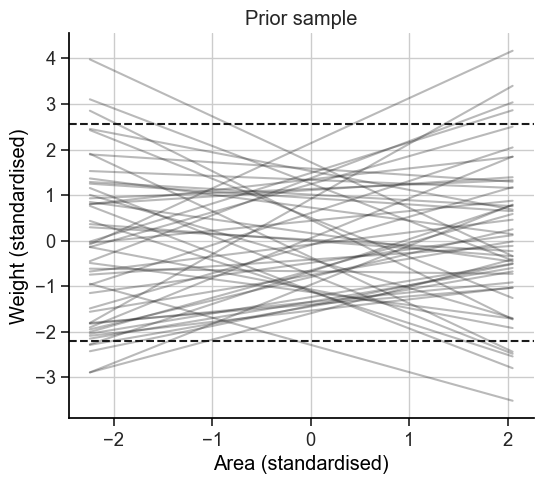

In [110]:
plot_fox_weight_prior_sample_lines(prior_trace_6h3, foxes, xlabel="Area (standardised)");

This is a reasonable uninformed prior.
I'm okay with this because I'm not certain that a larger area means that the foxes will be heavier.
In the DAG there is an indirect effect through `groupsize` that might lead to a counter-intuitive effect on `weight`.

I'm happy with the priors so now let's fit the model

In [67]:
with m_6h3:
    trace_6h3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_area, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


First let's check the sampling.

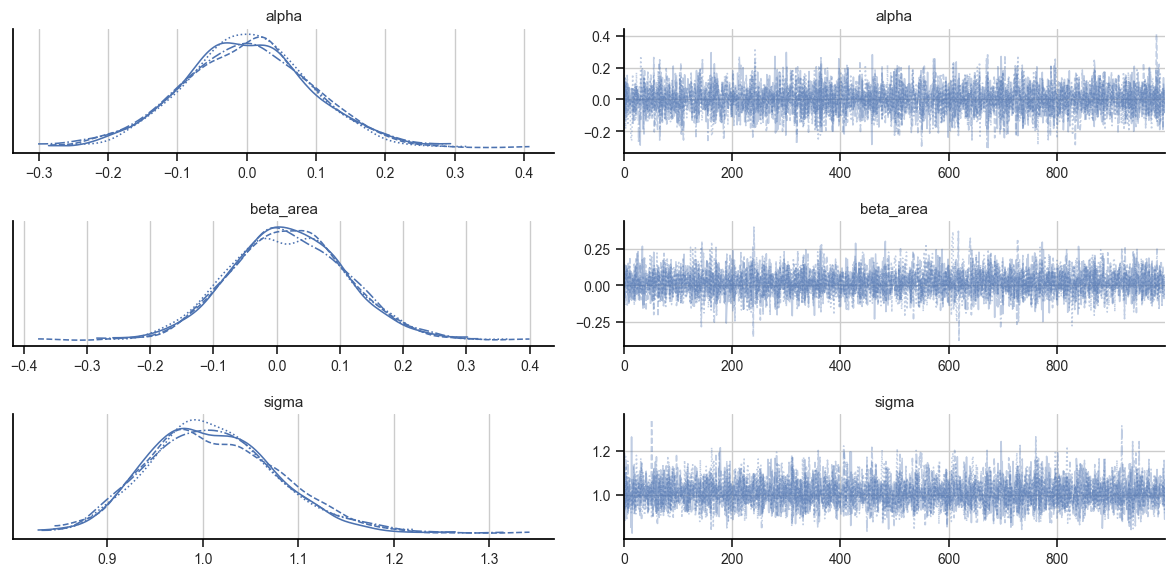

In [68]:
axs = az.plot_trace(trace_6h3, var_names=["~mu"])
axs.ravel()[0].get_figure().tight_layout();

Now let's look at the posteriors.

In [69]:
az.summary(
    trace_6h3,
    var_names=["~mu"],
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.093,-0.141,0.155,0.001,0.001,6668.0,3224.0,1.0
beta_area,0.019,0.091,-0.129,0.159,0.001,0.001,6862.0,3167.0,1.0
sigma,1.011,0.067,0.907,1.118,0.001,0.001,5710.0,2990.0,1.0


The coefficient of `area` is basically centred at zero with a pretty tight posterior.
From this it we can reasonably conclude that there is no causal effect.

Just to check this is reasonable I'll plot the posterior regression line.

In [94]:
def plot_posterior_linear_model(
    x, mu, hdi_prob=0.89, smooth=True, smooth_kwargs=None, color=None, ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot mu
    mu_mean = mu.mean(dim=["chain", "draw"])
    if smooth:
        x_plot, mu_mean = smooth_plot_data(x, mu_mean, smooth_kwargs)
    ax.plot(
        x_plot,
        mu_mean,
        color=color,
    )

    # plot hdi around mu
    mu_hdi = az.hdi(mu, hdi_prob=hdi_prob).mu
    if smooth:
        x_plot, mu_hdi = smooth_plot_data(x, mu_hdi, smooth_kwargs)

    ax.fill_between(
        x_plot,
        mu_hdi[:, 0],
        mu_hdi[:, 1],
        color=color,
        alpha=0.3,
    )

    return ax

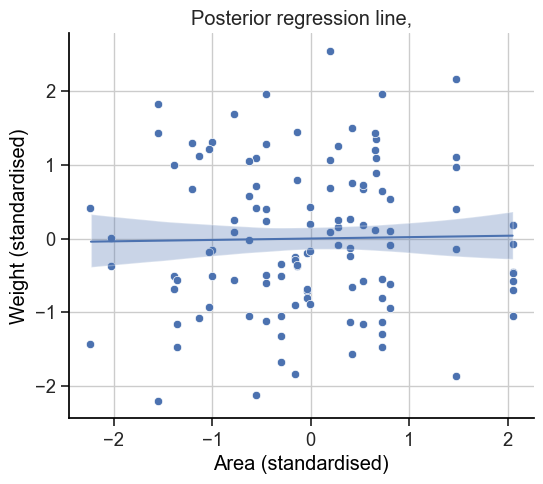

In [109]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    foxes,
    x="area_norm",
    y="weight_norm",
    ax=ax,
)

plot_posterior_linear_model(
    trace_6h3.constant_data.area_norm,
    trace_6h3.posterior.mu,
    ax=ax,
)

ax.set(
    xlabel="Area (standardised)",
    ylabel="Weight (standardised)",
    title="Posterior regression line,",
);

Yes, I believe this.

### 6H4

Now infer the causal impact of adding food to a territory.
Would this make foxes heavier?
Which covariates do you need to adjust for to estimate the total causal influence of food?

---

We don't need to adjust for any covariates.
In particular we shouldn't adjust for `groupsize` as part of the effect of `avgfood` is mediated through `groupsize`.

In [71]:
coords = {
    "obs_id": foxes.index,
}
with pm.Model(coords_mutable=coords) as m_6h4:
    # data
    avgfood_norm = pm.MutableData("avgfood_norm", foxes.avgfood_norm, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_avgfood = pm.Normal("beta_avgfood", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_avgfood * avgfood_norm, dims="obs_id")

    # likelihood
    weight_norm = pm.Normal(
        "weight_norm", mu=mu, sigma=sigma, observed=foxes.weight_norm, dims="obs_id"
    )

    # hit the sample button
    prior_trace_6h4 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta_avgfood, sigma, weight_norm]


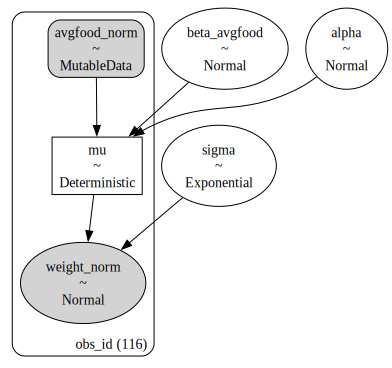

In [85]:
m_6h4.to_graphviz()

Plot some prior lines

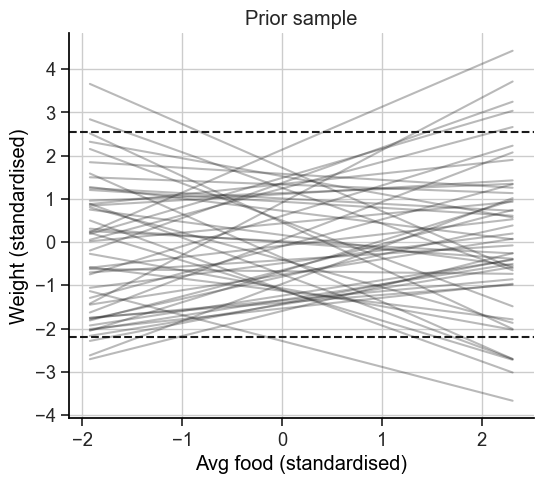

In [106]:
plot_fox_weight_prior_sample_lines(
    prior_trace_6h4,
    foxes,
    feature="avgfood_norm",
    coef="beta_avgfood",
    xlabel="Avg food (standardised)",
);

Now sample

In [86]:
with m_6h4:
    trace_6h4 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_avgfood, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


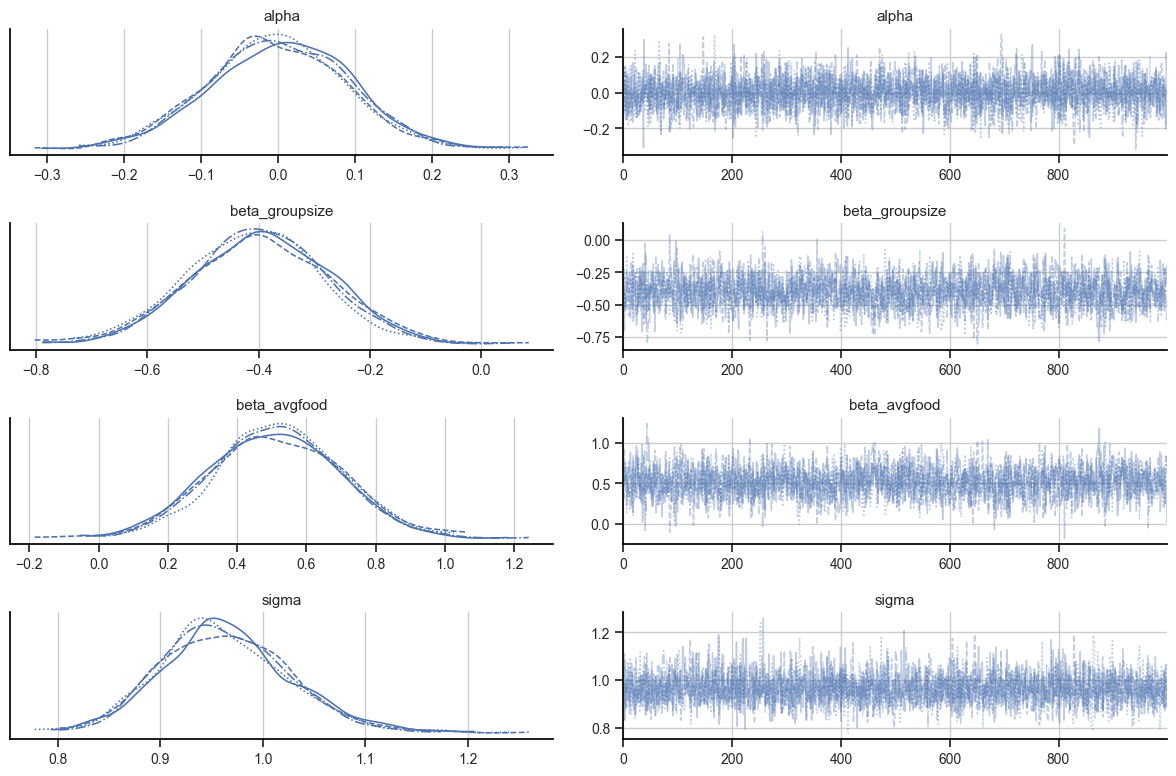

In [136]:
axs = az.plot_trace(
    trace_6h4,
    var_names=["~mu"],
)
axs.ravel()[0].get_figure().tight_layout();

Looks fine so lets look at a summary of the posteriors.

In [87]:
az.summary(
    trace_6h4,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.09,-0.15,0.14,0.0,0.0,6843.88,3107.46,1.0
beta_avgfood,-0.02,0.09,-0.17,0.13,0.0,0.0,5796.91,3164.37,1.0
sigma,1.01,0.07,0.91,1.12,0.0,0.0,5577.13,3112.68,1.0


This shows essentially no effect from food.

I want to plot the posterior regression line against the data.

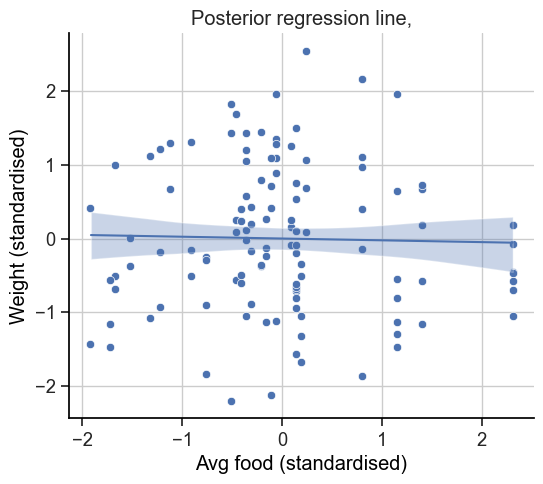

In [108]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    foxes,
    x="avgfood_norm",
    y="weight_norm",
    ax=ax,
)

plot_posterior_linear_model(
    trace_6h4.constant_data.avgfood_norm,
    trace_6h4.posterior.mu,
    ax=ax,
)

ax.set(
    xlabel="Avg food (standardised)",
    ylabel="Weight (standardised)",
    title="Posterior regression line,",
);

Yes, I believe this.
The conclusion is that adding more food to a territory wouldn't make the foxes heavier.

### 6H5

Now infer the causal impact of group size.
Which covariates do you need to adjust for?
Looking at the posterior distribution of the resulting model, what do you think explains these data?
That is, can you explain the estimate for all three problems?
How do they go together?

---

Now there is a backdoor through `avgfood` that we need to control for.

In [138]:
coords = {
    "obs_id": foxes.index,
}
with pm.Model(coords_mutable=coords) as m_6h5:
    # data
    groupsize_norm = pm.MutableData(
        "groupsize_norm", foxes.groupsize_norm, dims="obs_id"
    )
    avgfood_norm = pm.MutableData("avgfood_norm", foxes.avgfood_norm, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_groupsize = pm.Normal("beta_groupsize", mu=0, sigma=0.5)
    beta_avgfood = pm.Normal("beta_avgfood", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha + beta_avgfood * avgfood_norm + beta_groupsize * groupsize_norm,
        dims="obs_id",
    )

    # likelihood
    weight_norm = pm.Normal(
        "weight_norm", mu=mu, sigma=sigma, observed=foxes.weight_norm, dims="obs_id"
    )

    # hit the sample button
    prior_trace_6h5 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta_avgfood, beta_groupsize, sigma, weight_norm]


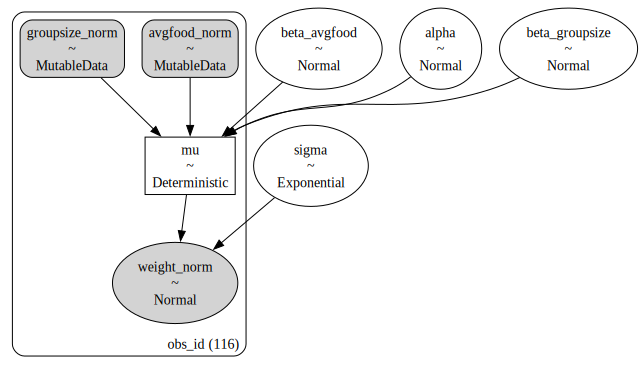

In [139]:
m_6h5.to_graphviz()

I'll plot sample prior lines individually for each feature.
The is equivalent to holding the other feature constant at zero.

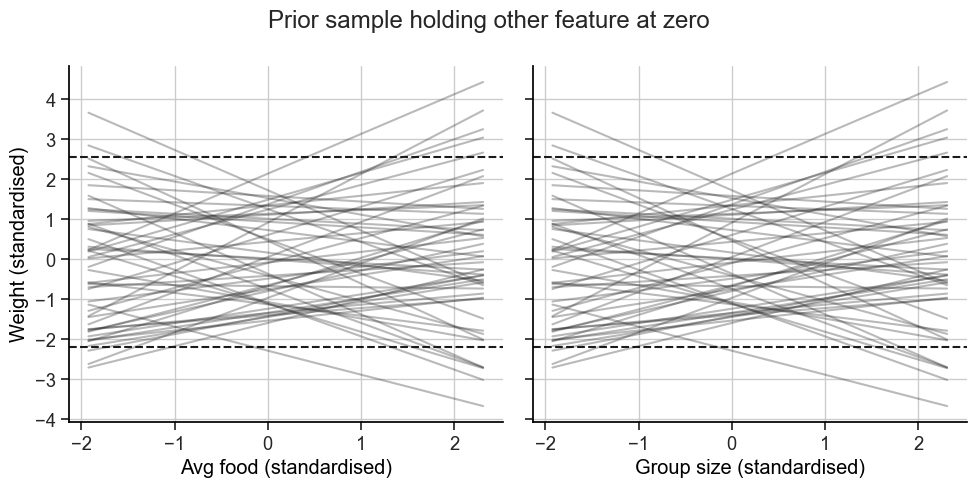

In [140]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_fox_weight_prior_sample_lines(
    prior_trace_6h5,
    foxes,
    feature="avgfood_norm",
    coef="beta_avgfood",
    xlabel="Avg food (standardised)",
    ax=axs[0],
)
plot_fox_weight_prior_sample_lines(
    prior_trace_6h5,
    foxes,
    feature="avgfood_norm",
    coef="beta_avgfood",
    xlabel="Group size (standardised)",
    ax=axs[1],
)

axs[0].set(title=None)
axs[1].set(ylabel=None, title=None)


fig.suptitle("Prior sample holding other feature at zero")
fig.tight_layout();

These are probably too weak once you take both varying into account, but it's good enough.

Now let's sample the model

In [141]:
with m_6h5:
    trace_6h5 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_groupsize, beta_avgfood, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


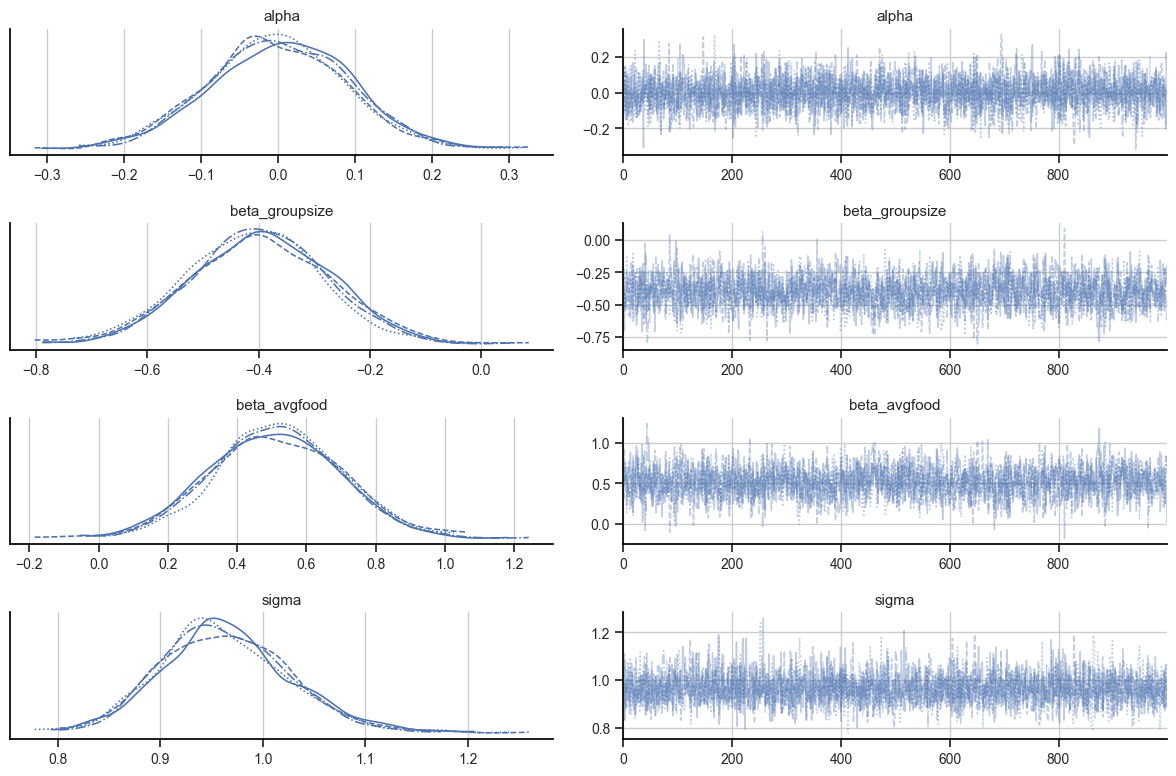

In [142]:
axs = az.plot_trace(trace_6h4, var_names=["~mu"])
axs.ravel()[0].get_figure().tight_layout();

That's sampled fine.
Let's look at a summary.

In [143]:
az.summary(
    trace_6h5,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.14,0.10,-0.04,0.28,0.0,0.0,2462.94,2355.95,1.0
beta_groupsize,-0.40,0.12,-0.60,-0.22,0.0,0.0,1977.18,2284.01,1.0
beta_avgfood,0.51,0.19,0.19,0.79,0.0,0.0,2066.56,2384.91,1.0
sigma,0.96,0.06,0.87,1.07,0.0,0.0,3467.65,2443.64,1.0


Cool.
Now we're getting some real association.
It looks like increasing group size decreases weight and increasing food increases weight *if we hold group size constant*.

This suggests an explanation for the results.
Increasing area or average food has no effect on weight because it is mediated through group size.
That is, increasing average food increases weight but also increases group size, which decreases weight - more foxes means less food for each fox.
So in aggregate increasing area or average food as no effect on weight.

### 6H6

Consider your own research question.
Draw a DAG to represent it.
What are the testable implications of your DAG?
Are there any variables you could condition on to close all backdoor paths?
Are there unobserved variables that you have omitted?
Would a reasonable colleague imagine additional threats to causal inference that you have ignored?

---

### 6H7

For the DAG you made in the previous problem, can you write a data generating simulation for it?
Can you design one or more statistical models to product causal estimated?
If so, try to calculate interesting counterfactuals.
If not, use the simulation to estimate the size of the bias you might expect.
Under what conditions would you, for example, infer the opposite of a true causal effect?

---